In [ ]:
!pip install -q kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

 82% 66.0M/80.9M [00:00<00:00, 179MB/s]
100% 80.9M/80.9M [00:00<00:00, 153MB/s]


In [ ]:
!unzip "/content/sentiment140.zip" -d "/content/drive/MyDrive/DataSets/Twitter_Data"

Archive:  /content/sentiment140.zip
  inflating: /content/drive/MyDrive/DataSets/Twitter_Data/training.1600000.processed.noemoticon.csv  


In [ ]:
#Requirements
!pip install num2words
!pip install emoji
!pip install autocorrect
!pip install spacy
!python -m spacy download en_core_web_lg

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from nltk.corpus import stopwords
import nltk
from num2words import num2words
import string
string.punctuation
import re
import spacy
from spacy.lang.en import stop_words as spacy_stopwords
import nltk
nltk.download('stopwords')
import emoji
from autocorrect import Speller
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Description**

---



(1) Importing Dataset

(2) Apply preprocessing data techniques

(3) Apply TF-IDF

(4) Apply Logistic Regression and XGBClassigier

(5) Compare the steps

# **Introduction**
In this assignment,The Sentiment140 dataset is chosen to perform the potential NLP tasks.

1 **Dataset Chosen** :

 Sentiment140 - It consists of a large collection of tweets from the social media platform Twitter. Each tweet in the dataset is labeled with sentiment polarity, indicating whether the tweet expresses a positive, negative, or neutral sentiment.

**Information about the dataset**:

0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

1 - the id of the tweet (2087)

2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)

3 - the query (lyx). If there is no query, then this value is NO_QUERY.

4 - the user that tweeted (robotickilldozr)

5 - the text of the tweet (Lyx is cool)

In [4]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING='ISO-8859-1'
df = pd.read_csv("/content/drive/MyDrive/DataSets/Twitter_Data/training.1600000.processed.noemoticon.csv",
                encoding = DATASET_ENCODING,names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1008127,4,1880771478,Fri May 22 02:26:49 PDT 2009,NO_QUERY,krist0ph3r,turned the volume up too high to hear my phone...
1190142,4,1983659805,Sun May 31 13:35:03 PDT 2009,NO_QUERY,ioncontrol,@KTVBScottEvans wow really? Its not even 4 yet!
1201568,4,1985698561,Sun May 31 17:36:17 PDT 2009,NO_QUERY,lightingguru44,this makes 40 hours without sleep(5am yesterda...
185141,0,1967887678,Fri May 29 20:23:31 PDT 2009,NO_QUERY,michaelp_golf,looks like it's not going to be a McNugget fin...
662448,0,2243613848,Fri Jun 19 13:40:30 PDT 2009,NO_QUERY,stephj1216,Going to work


In [5]:
df.shape

(1600000, 6)

In [6]:
##removing the columns whihc are not required
df.drop(['ids','date','flag','user'],axis=1,inplace=True)

In [7]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df['target'].unique()#To get unique values from taget column

array([0, 4])

In [9]:
df['target'] = df['target'].replace(4,1)#Replacing the value 4 with 1

In [10]:
df['target'].value_counts()

0    800000
1    800000
Name: target, dtype: int64

In [11]:
#Separating Positive and -Ve Values
data_pos = df[df['target'] == 1]
data_neg = df[df['target'] == 0]

# **Data Preprocessing**
The Preprocessing steps taken are:

1-**Lower Casing**: Each text is converted to lowercase.

2-**Replacing URLs**: Links starting with 'http' or 'https' or 'www' are replaced by ''.

3-**Replacing Usernames**: Replace @Usernames with word ''. [eg: '@Kaggle' to ''].

4-**Replacing Emojis**: Replace emojis by using a regex expression. [eg: ':)' to '']

5-**Replacing Contractions**: Replacing contractions with their meanings. [eg: "can't" to 'can not']

6-**Removing Non-Alphabets/puncutations**: Replacing characters except Digits, Alphabets and pre-defined Symbols with a space.

7-**Removing stopwords**

In [12]:
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = r'@[^\s]+'
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1"

In [13]:
df.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [14]:
spell = Speller(lang='en')
nlp = spacy.load('en_core_web_lg')

STOPWORDS = set(stopwords.words('english'))


def LowerCase(text):
    return text.lower()

def RemoveURLs(text):
    return re.sub(urlPattern,'',text)

def RemoveUsernames(text):
    return re.sub(userPattern,'',text)

def Replacing_repeating_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)


In [15]:
# 1. Convert to lower case
df['processedText']=df['text'].apply(lambda text: LowerCase(text))

# 2. Remove all URLs
df['processedText']=df['processedText'].apply(lambda text: RemoveURLs(text))

#3. Remove usernames
df['processedText']=df['processedText'].apply(lambda text: RemoveUsernames(text))

df.head()

,target,text,processedText
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- awww, that's a bummer. you shoulda got da..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."


In [16]:
#4. Replace emojis

def replaceEmojis(text):
    return " ".join([" ".join(emoji.demojize(x)[1:-1].split("_")) if emoji.is_emoji(x) else x for x in text.split()])

df['processedText']=df['processedText'].apply(lambda text: replaceEmojis(text))

In [17]:
df.tail()

,target,text,processedText
1599995,1,Just woke up. Having no school is the best fee...,just woke up. having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdb.com - very cool to hear old walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover? ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time!!! ...
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...,happy #charitytuesday


In [18]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.7 MB/s eta 0:00:00


In [19]:
#6. replace contractions
import contractions
def ReplaceContractions(text):
    text=contractions.fix(text)
    return text

df['processedText']=df['processedText'].apply(lambda x: ReplaceContractions(x))

In [20]:
#7. remove punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def RemovePunct(text ):
    # Remove non-alphanumeric and symbols (puntuations)
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['processedText']=df['processedText'].apply(lambda x: RemovePunct(x))

In [21]:
df.tail()

,target,text,processedText
1599995,1,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom very cool to hear old walt intervie...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,happy 38th birthday to my boo of alll time tup...
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...,happy charitytuesday


In [22]:
#8. replace repeating chars
def replacing_repeating_chars(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['processedText']=df['processedText'].apply(lambda x: replacing_repeating_chars(x))

In [23]:
#9. Remove Stop Words
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['processedText'] = df['processedText'].apply(lambda text: cleaning_stopwords(text))

In [24]:
"""def RemoveSpellMistakes(text):
    # Replacing mistake of spellings
    text = spell(text)
    return text

df['processedText']=df['processedText'].apply(lambda text: RemoveSpellMistakes(text))"""

"def RemoveSpellMistakes(text):\n    # Replacing mistake of spellings\n    text = spell(text)\n    return text\n\ndf['processedText']=df['processedText'].apply(lambda text: RemoveSpellMistakes(text))"

In [26]:
#10. Removing WhiteSpaces
def removeWhitespaces(text):
    #removing whitespaces
    text = text.strip()
    return text


df['processedText']=df['processedText'].apply(lambda text: removeWhitespaces(text))



In [27]:
df.tail()

,target,text,processedText
1599995,1,Just woke up. Having no school is the best fee...,woke schol best feling ever
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom col hear old walt interviews â«
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,hapy 38th birthday bo al time tupac amaru shakur
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...,hapy charitytuesday


In [28]:
#11. Removing Numbers

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)


df['processedText']=df['processedText'].apply(lambda text: cleaning_numbers(text))


In [29]:
df.tail()

,target,text,processedText
1599995,1,Just woke up. Having no school is the best fee...,woke schol best feling ever
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,thewdbcom col hear old walt interviews â«
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,ready mojo makeover ask details
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,hapy th birthday bo al time tupac amaru shakur
1599999,1,happy #charitytuesday @theNSPCC @SparksCharity...,hapy charitytuesday


# **Pickling the file**

In [30]:
df.to_pickle('preprocessedtext.pkl')

In [31]:
dataPreprocessed = pd.read_pickle("preprocessedtext.pkl")

# **Applying tf-IDF **

In [33]:
df_train, df_test, y_train_basic, y_test_basic = train_test_split(dataPreprocessed['processedText'], dataPreprocessed.target, test_size=0.2, random_state=0)

In [35]:
tfidf_vectorizer_train = TfidfVectorizer()
tfidf_vectorizer_train.fit(dataPreprocessed['processedText'])
X_train_basic = tfidf_vectorizer_train.transform(df_train)
X_test_basic = tfidf_vectorizer_train.transform(df_test)

print(X_train_basic.shape)

(1280000, 363842)


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Fucntion to calculate the score and confusion matrix to print
def metrixAndScoring(test, pred, fold=0):
    if fold:
        return [fold, precision_score(test, pred), recall_score(test, pred), f1_score(test, pred), accuracy_score(test, pred), roc_auc_score(test, pred)]
    else:
        # Confusion Matrix Display
        cf_matrix = confusion_matrix(test, pred)
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        s = sns.heatmap(cf_matrix, annot=labels,fmt='')
        s.set_title("Confusion metric")
        plt.show()
        s.set(ylabel='True labels', xlabel='Predicted labels')
        return [precision_score(test, pred), recall_score(test, pred),
                f1_score(test, pred), accuracy_score(test, pred)]+ group_percentages



AllScores = []
def fittingModel(name, model, x_train, x_test ,y_train, y_test):
    # fitting the data to the given model
    model.fit(x_train, y_train)
    # displaying the interpretated values
    returnValues = [name]+metrixAndScoring(y_test, model.predict(x_test))
    AllScores.append(returnValues)
    display(pd.DataFrame([[returnValues[1], returnValues[2], returnValues[3], returnValues[4]]], columns=['Precision', 'Recall', 'F1', 'Accuracy']).round(2))
    return model

# **Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


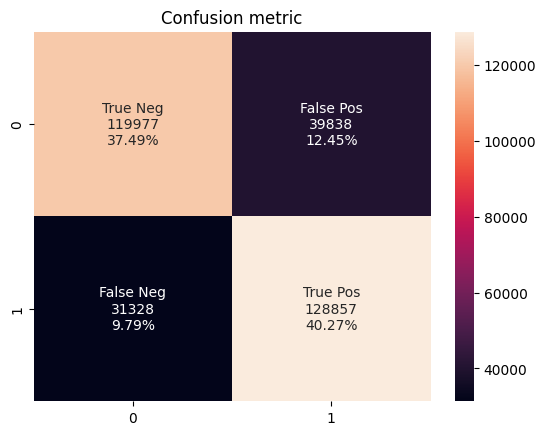

,Precision,Recall,F1,Accuracy
0,0.76,0.8,0.78,0.78


In [38]:
log_model = fittingModel("LogisticRegression" , LogisticRegression(), X_train_basic, X_test_basic, y_train_basic, y_test_basic )

# **XGBClassifier**

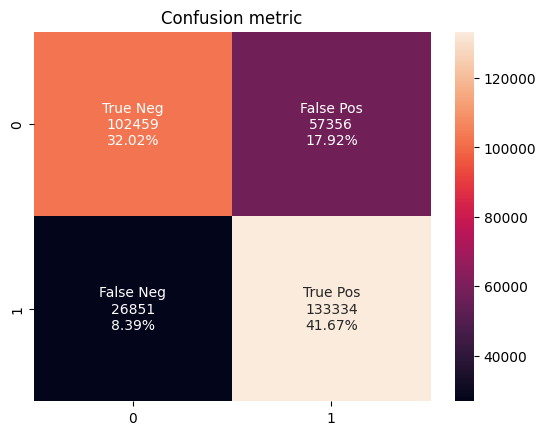

,Precision,Recall,F1,Accuracy
0,0.7,0.83,0.76,0.74


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
fittingModel("XGBClassifier", XGBClassifier(), X_train_basic, X_test_basic, y_train_basic, y_test_basic)

# **Comparison of Logistic Regression and XGBClassifier**


***Logistic Regression performed better than XGBClassifier. The time taken by the XGBClassifier also more compared to logistic regression.***